In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
sns.set()

In [ ]:
#https://www.kaggle.com/mgmarques/customer-segmentation-and-market-basket-analysis/data
df = pd. read_excel('Online Retail.xlsx');

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df.shape

(541909, 8)

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Preprocessing

## Check the customer in every country

In [ ]:
customer_count = df[['CustomerID', 'Country']].drop_duplicates()
customer_count = customer_count.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

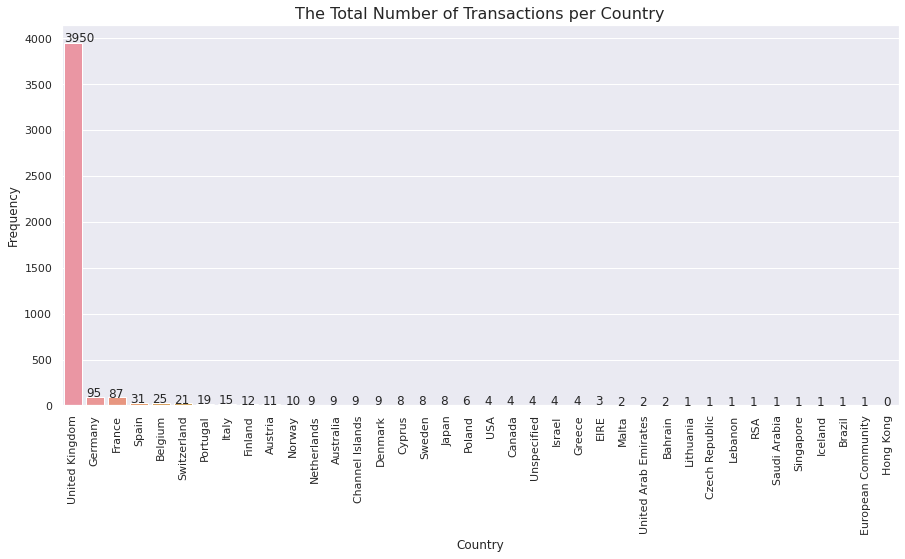

In [ ]:
plt.figure(figsize=(15,7))
ax = sns.barplot(x=customer_count['Country'], y=customer_count['CustomerID'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.ylabel('Frequency')
plt.title('The Total Number of Transactions per Country', fontsize=16)
plt.show()

### Data Clean Up (Choose country with the most customer)
- Get the customer data only from UK
- Remove data with null customer ID
- Remove the data with minus quantity value

In [ ]:
df[df['Quantity']<0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [ ]:
#there isn't relation between the negative data, so I decide to delete the negative data
df.iloc[234:237]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
234,536390,85099B,JUMBO BAG RED RETROSPOT,100,2010-12-01 10:19:00,1.65,17511.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [ ]:
#select the UK data
df = df[df['Country'] == 'United Kingdom']
#remove the data with null customer ID
df = df[pd.notnull(df['CustomerID'])]
#remove data with negative quantitiy
df = df[df['Quantity']>0]

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,354345.000000,354345.000000,354345.000000
mean,12.048913,2.963793,15552.436219
std,190.428127,17.862067,1594.546025
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15522.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,8142.750000,18287.000000


# Customer Segmentation

## RFM
- Recency (R): check the earliest and the latest date of the transaction, then asssign the latest date to calculate transaction rescency.
- Frequency (F) : the number of invoices per costomer
- Monetary (M): how much they spend their money for our product
<p>Use scale 1-4 to determine the value of RFM (1 indicate high and 4 indicate low, u kan use quantile)
<p>Then concat RFM Score. Example 113</p>  


<b>First, create total price feature</b>

In [ ]:
df['TotalPrice'] = df['Quantity']*df['UnitPrice']

<b>Check the earliest and latest date of the transaction</b>

In [ ]:
print("Min Date: ",df['InvoiceDate'].min()," | Max Date: ", df['InvoiceDate'].max())

Min Date:  2010-12-01 08:26:00  | Max Date:  2011-12-09 12:49:00


In [ ]:
import datetime as dt
# now = dt.date(2011,12,10)
now = np.datetime64('2011-12-10')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

<b>RFM Table</b>

In [ ]:
rfm = df.groupby('CustomerID').agg({'InvoiceDate' : lambda x: (now-x.max()).days,
                                    'InvoiceNo': lambda x : len(x),
                                    'TotalPrice': lambda x : x.sum()})
rfm.rename(columns={'InvoiceDate': 'recency','InvoiceNo': 'frequency', 'TotalPrice': 'monetary_value'}, inplace=True)
rfm.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


## Get the rfm value

In [ ]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,17.0,17.0,300.04
0.50,50.0,41.0,651.82
0.75,142.0,99.0,1575.89


In [ ]:
quantil_dict = quantiles.to_dict()

In [ ]:
rfm_segmented = rfm

In [ ]:
# 1 is better then 4
# if the different between now and latest date is much, mean bad
def RecencyScore(x,p,d):
  if x <= d[p][0.25]:
    return 1
  elif x <= d[p][0.5]:
    return 2
  elif x <= d[p][0.75]:
    return 3
  else:
    return 4
# more spend better
def MonetaryScore (x,p,d):
  if x <= d[p][0.25]:
    return 4
  elif x <= d[p][0.5]:
    return 3
  elif x <= d[p][0.75]:
    return 2
  else:
    return 1

In [ ]:
rfm['R'] = rfm['recency'].apply(RecencyScore, args=('recency', quantiles))
rfm['F'] = rfm['frequency'].apply(MonetaryScore, args=('frequency', quantiles))
rfm['M'] = rfm['monetary_value'].apply(MonetaryScore, args=('monetary_value', quantiles))
rfm.head()

,recency,frequency,monetary_value,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


In [ ]:
rfm['RFMtotal'] = rfm.R+rfm.F+rfm.M
rfm['RFMScore'] = rfm.R.map(str)+rfm.F.map(str)+rfm.M.map(str)
rfm['RFMScore'] = rfm['RFMScore'].astype(int)
rfm.head()

,recency,frequency,monetary_value,R,F,M,RFMtotal,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,9,441
12747.0,2,103,4196.01,1,1,1,3,111
12748.0,0,4596,33719.73,1,1,1,3,111
12749.0,3,199,4090.88,1,1,1,3,111
12820.0,3,59,942.34,1,2,2,5,122


In [ ]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3921 entries, 12346.0 to 18287.0
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         3921 non-null   int64  
 1   frequency       3921 non-null   int64  
 2   monetary_value  3921 non-null   float64
 3   R               3921 non-null   int64  
 4   F               3921 non-null   int64  
 5   M               3921 non-null   int64  
 6   RFMtotal        3921 non-null   int64  
 7   RFMScore        3921 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 275.7 KB


## KMeans

In [ ]:
# from customerSegments import loyal_customers, big_spenders, lost_customers, bad_spenders

# rfm_try = rfm.copy()

# score_labels = ['Green', 'Bronze', 'Silver', 'Gold']
# score_groups = pd.qcut(rfm_try.RFMScore, q = 4, labels = score_labels)
# rfm_try['RFM_Level'] = score_groups.values
# rfm_try = rfm_try.sort_values(by='RFMScore', ascending=False)
# rfm_try.head()

In [ ]:
# rfm_try.RFM_Level.value_counts()

In [ ]:
# rfm_try.iloc[975:985]

In [ ]:
#https://www.kaggle.com/tklimonova/online-retail-cohort-and-rfm-analysis
#https://retail.aspiresys.com/customer-segmentation-using-rfm-analysis-demo?elqTrackId=23942feb0d1a4dcf908a23515a20947f&elq=00000000000000000000000000000000&elqaid=1115&elqat=2&elqCampaignId=

In [ ]:
rfm.head()
rfm2 = rfm.copy()
rfm3 = rfm.copy()
rfm4 = rfm.copy()

In [ ]:
feature2 = rfm[['F','M']]
feature3 = rfm[['R','F','M']]
feature4 = rfm[['R','F','M','RFMScore']]

### Kmeans using  Frequency and Monetary

In [ ]:
feature2.head()

,F,M
CustomerID,,
12346.0,4,1
12747.0,1,1
12748.0,1,1
12749.0,1,1
12820.0,2,2


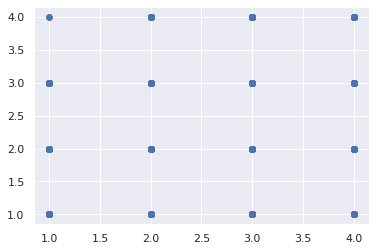

In [ ]:
plt.scatter(feature2['F'], feature2['M'])

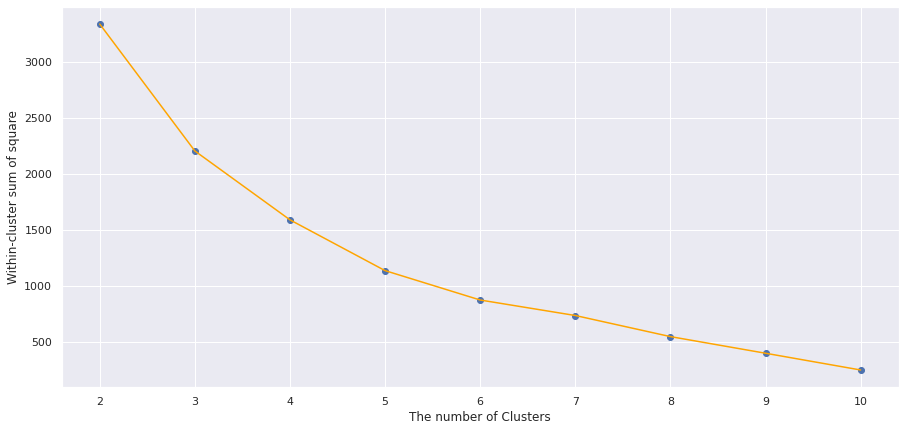

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range (2,11):
    kmeans = KMeans(i)
    kmeans.fit(feature2)
    wcss.append(kmeans.inertia_)

#plot the elbow
clstr = range(2,11)
plt.figure(figsize=(15,7))
plt.scatter(clstr, wcss)
plt.plot(clstr,wcss, color='orange')
plt.xlabel("The number of Clusters")
plt.ylabel("Within-cluster sum of square")
plt.show()

In [ ]:
kmeans = KMeans(5)
kmeans.fit(feature2)
label = kmeans.predict(feature2)
rfm2['Label'] = label
rfm2.head()

,recency,frequency,monetary_value,R,F,M,RFMtotal,RFMScore,Label
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,9,441,4
12747.0,2,103,4196.01,1,1,1,3,111,2
12748.0,0,4596,33719.73,1,1,1,3,111,2
12749.0,3,199,4090.88,1,1,1,3,111,2
12820.0,3,59,942.34,1,2,2,5,122,1


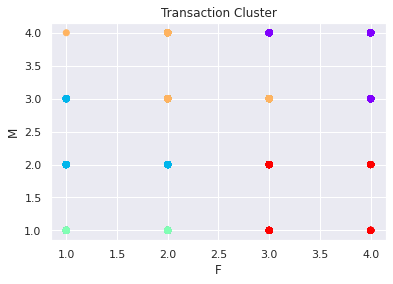

In [ ]:
plt.scatter(feature2['F'], feature2['M'], c=rfm2['Label'], cmap='rainbow')
plt.xlabel('F')
plt.ylabel('M')
plt.title('Transaction Cluster')
plt.show()

### Kmeans using  Recency, Frequency, and Monetary

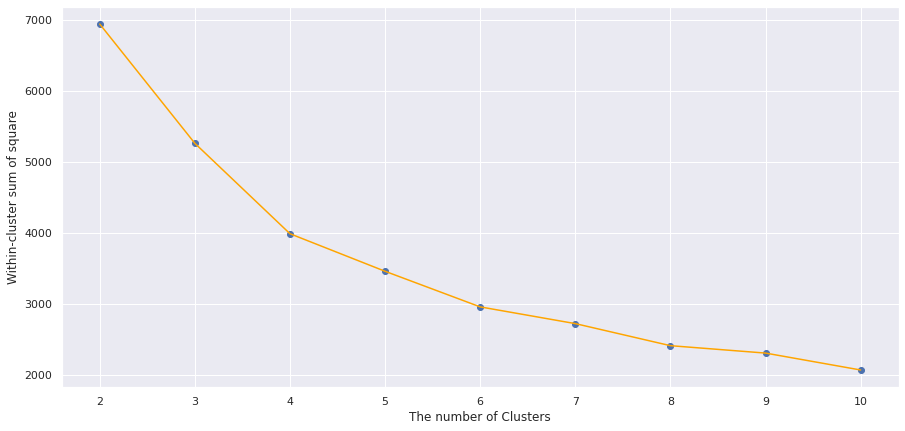

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range (2,11):
    kmeans = KMeans(i)
    kmeans.fit(feature3)
    wcss.append(kmeans.inertia_)

#plot the elbow
clstr = range(2,11)
plt.figure(figsize=(15,7))
plt.scatter(clstr, wcss)
plt.plot(clstr,wcss, color='orange')
plt.xlabel("The number of Clusters")
plt.ylabel("Within-cluster sum of square")
plt.show()

In [ ]:
kmeans = KMeans(4)
kmeans.fit(feature3)
label = kmeans.predict(feature3)
rfm3['Label'] = label
rfm3.head()

,recency,frequency,monetary_value,R,F,M,RFMtotal,RFMScore,Label
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,9,441,1
12747.0,2,103,4196.01,1,1,1,3,111,3
12748.0,0,4596,33719.73,1,1,1,3,111,3
12749.0,3,199,4090.88,1,1,1,3,111,3
12820.0,3,59,942.34,1,2,2,5,122,3


In [ ]:
rfm3['Label'].value_counts()

2    1252
3    1233
0     740
1     696
Name: Label, dtype: int64

### Kmeans using Recency, Frequency, Monetary, and FRMScore

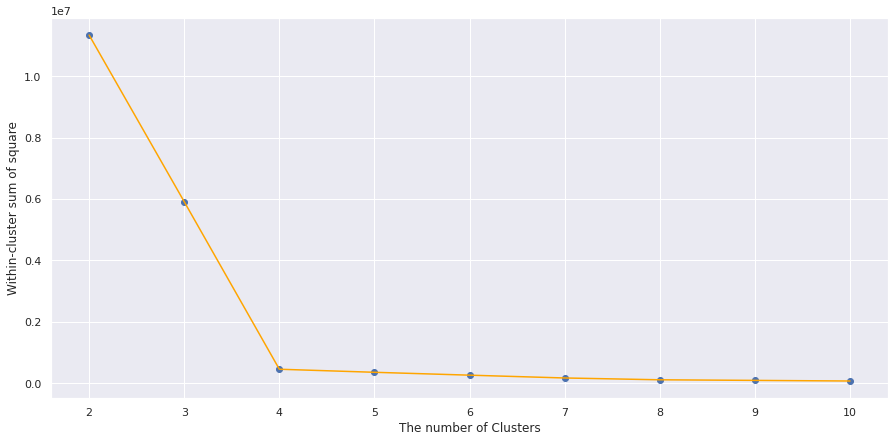

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range (2,11):
    kmeans = KMeans(i)
    kmeans.fit(feature4)
    wcss.append(kmeans.inertia_)

#plot the elbow
clstr = range(2,11)
plt.figure(figsize=(15,7))
plt.scatter(clstr, wcss)
plt.plot(clstr,wcss, color='orange')
plt.xlabel("The number of Clusters")
plt.ylabel("Within-cluster sum of square")
plt.show()

In [ ]:
kmeans = KMeans(4)
kmeans.fit(feature4)
label = kmeans.predict(feature4)
rfm4['Label'] = label
rfm4.head()

,recency,frequency,monetary_value,R,F,M,RFMtotal,RFMScore,Label
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,9,441,0
12747.0,2,103,4196.01,1,1,1,3,111,1
12748.0,0,4596,33719.73,1,1,1,3,111,1
12749.0,3,199,4090.88,1,1,1,3,111,1
12820.0,3,59,942.34,1,2,2,5,122,1


In [ ]:
rfm4.sort_values(by='Label', ascending=False)

,recency,frequency,monetary_value,R,F,M,RFMtotal,RFMScore,Label
CustomerID,,,,,,,,,
18287.0,42,70,1837.28,2,2,1,5,221,3
14139.0,46,26,415.82,2,3,3,8,233,3
16243.0,33,51,409.10,2,2,3,7,223,3
16245.0,23,90,1413.66,2,2,2,6,222,3
16258.0,45,135,5203.51,2,1,1,4,211,3
...,...,...,...,...,...,...,...,...,...
17110.0,165,12,163.30,4,4,4,12,444,0
14450.0,180,40,483.25,4,3,3,10,433,0
17117.0,288,9,116.20,4,4,4,12,444,0


<b>See the data characteristic by filter the label one by one</b>

In [ ]:
rfm4[rfm4['Label']==0].head()

,recency,frequency,monetary_value,R,F,M,RFMtotal,RFMScore,Label
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,9,441,0
12821.0,214,6,92.72,4,4,4,12,444,0
12829.0,336,11,293.00,4,4,4,12,444,0
12831.0,262,9,215.05,4,4,4,12,444,0
12833.0,145,24,417.38,4,3,3,10,433,0


In [ ]:
rfm4[rfm4['Label']==1].head()

,recency,frequency,monetary_value,R,F,M,RFMtotal,RFMScore,Label
CustomerID,,,,,,,,,
12747.0,2,103,4196.01,1,1,1,3,111,1
12748.0,0,4596,33719.73,1,1,1,3,111,1
12749.0,3,199,4090.88,1,1,1,3,111,1
12820.0,3,59,942.34,1,2,2,5,122,1
12826.0,2,91,1474.72,1,2,2,5,122,1


In [ ]:
rfm4[rfm4['Label']==2].head()

,recency,frequency,monetary_value,R,F,M,RFMtotal,RFMScore,Label
CustomerID,,,,,,,,,
12822.0,70,46,948.88,3,2,2,7,322,2
12823.0,74,5,1759.50,3,4,1,8,341,2
12824.0,59,25,397.12,3,3,3,9,333,2
12836.0,59,175,2612.86,3,1,1,5,311,2
12842.0,70,34,1118.99,3,3,2,8,332,2


In [ ]:
rfm4[rfm4['Label']==3].head()

,recency,frequency,monetary_value,R,F,M,RFMtotal,RFMScore,Label
CustomerID,,,,,,,,,
12830.0,37,38,6814.64,2,3,1,6,231,3
12832.0,32,27,383.03,2,3,3,8,233,3
12838.0,33,123,683.13,2,1,2,5,212,3
12844.0,29,52,325.96,2,2,3,7,223,3
12847.0,22,91,871.54,2,2,2,6,222,3


In [ ]:
rfm4['Label'].value_counts()

1    1004
0     979
3     969
2     969
Name: Label, dtype: int64

# Market Basket Analysis

In [ ]:
dfm = pd. read_excel('Online Retail.xlsx');

In [ ]:
dfm['Description'] = dfm['Description'].str.strip() #remove white space in string
dfm.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
dfm['InvoiceNo'] = dfm['InvoiceNo'].astype('str')
dfm = dfm[~dfm['InvoiceNo'].str.contains('C')] #filter invoice no and return invoice that doesn't containt C
dfm =dfm[pd.notnull(dfm['CustomerID'])] #filter data where the customerID not null
dfm = dfm[dfm['Quantity']>0] #just select the data with quantity > 0
dfm.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [ ]:
basket = (dfm[dfm['Country']== 'United Kingdom'].groupby(['InvoiceNo', 'Description'])['Quantity'].sum()
          .unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 BIRDS CANVAS SCREEN,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 PINK HEN+CHICKS IN BASKET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 RAFFIA RIBBONS VINTAGE CHRISTMAS,3 ROSE MORRIS BOXED CANDLES,...,YELLOW DRAGONFLY HELICOPTER,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
#get relations
def encode_units(x):
    return 0 if x <= 0 else 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1) #remove postage as an items
basket_sets.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 BIRDS CANVAS SCREEN,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 PINK HEN+CHICKS IN BASKET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 RAFFIA RIBBONS VINTAGE CHRISTMAS,3 ROSE MORRIS BOXED CANDLES,...,YELLOW DRAGONFLY HELICOPTER,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## train the model

In [ ]:
# Generating Frequent Items
frequent_itemset = apriori(basket_sets, min_support=0.02, use_colnames=True)
frequent_itemset.head(20)

,support,itemsets
0,0.022404,(3 STRIPEY MICE FELTCRAFT)
1,0.037720,(6 RIBBONS RUSTIC CHARM)
2,0.025767,(60 CAKE CASES VINTAGE CHRISTMAS)
3,0.035257,(60 TEATIME FAIRY CAKE CASES)
4,0.026668,(72 SWEETHEART FAIRY CAKE CASES)
5,0.041444,(ALARM CLOCK BAKELIKE GREEN)
6,0.025467,(ALARM CLOCK BAKELIKE IVORY)
7,0.029491,(ALARM CLOCK BAKELIKE PINK)
8,0.045528,(ALARM CLOCK BAKELIKE RED)
9,0.031353,(ANTIQUE SILVER T-LIGHT GLASS)


In [ ]:
#generate rules
rules = association_rules(frequent_itemset, metric="lift", min_threshold=1)

In [ ]:
#https://infocenter.informationbuilders.com/wf80/index.jsp?topic=%2Fpubdocs%2FRStat16%2Fsource%2Ftopic49.htm
rules.head(100)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.041444,0.045528,0.027269,0.657971,14.451925,0.025382,2.790617
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.045528,0.041444,0.027269,0.598945,14.451925,0.025382,2.390084
2,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.037660,0.044567,0.027509,0.730463,16.390122,0.025831,3.544712
3,(GARDENERS KNEELING PAD KEEP CALM),(GARDENERS KNEELING PAD CUP OF TEA),0.044567,0.037660,0.027509,0.617251,16.390122,0.025831,2.514283
4,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.029611,0.036759,0.024266,0.819473,22.293137,0.023177,5.335706
...,...,...,...,...,...,...,...,...,...
71,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.024266,0.040723,0.020482,0.844059,20.726763,0.019494,6.151553
72,"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.028590,0.029611,0.020482,0.716387,24.192941,0.019635,3.421518
73,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",0.029611,0.028590,0.020482,0.691684,24.192941,0.019635,3.150691
74,(ROSES REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.040723,0.024266,0.020482,0.502950,20.726763,0.019494,1.963050


## Makeing Recomendation System

In [ ]:
#filter rule
rules[(rules['lift']>20)&(rules['confidence']>0.8)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.029611,0.036759,0.024266,0.819473,22.293137,0.023177,5.335706
70,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023004,0.036759,0.020482,0.890339,24.221015,0.019636,8.783841
71,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.024266,0.040723,0.020482,0.844059,20.726763,0.019494,6.151553


In [ ]:
basket_sets['PINK REGENCY TEACUP AND SAUCER'].sum()

493

In [ ]:
basket_sets['GREEN REGENCY TEACUP AND SAUCER'].sum()

612